In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas 

from scipy.optimize import minimize
from functools import partial


import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook as tqdm
import math


# Methode analytique 

In [2]:

def estimationAB(X):
    
    n=len(X)
    hbar=np.zeros(n)
    Ybar=np.zeros(n)
    hbar_etoile=np.zeros(n)
    Ybar_etoile=np.zeros(n)
    A1_chap_nom=np.zeros(n)
    A2_chap_nom=np.zeros(n)
    A1_chap_denom=np.zeros(n)
    A2_chap_denom=np.zeros(n)
    A1_chap=np.zeros(n)
    A2_chap=np.zeros(n)
    B1_chap=np.zeros(n)
    B2_chap=np.zeros(n)


    for k0 in range(4,n-4):    
        Y=F(k0,n)
        hbar[k0]=(1/k0)*sum(np.log(np.array(sorted(X[:k0]))))
        Ybar[k0]=(1/k0)*sum(Y[:k0])
        hbar_etoile[k0]=(1/(n-k0))*sum(np.log(np.array(sorted(X[k0:]))))
        Ybar_etoile[k0]=(1/(n-k0))*sum(np.array(Y[k0:]))

        #estimation des A1 B1 A2 B2
        
        #estimation A1
        A1_chap_nom[k0]=sum((np.log(np.array(sorted(X[:k0])))-hbar[k0])*(np.array(Y[:k0])-np.array(Ybar[k0])))
        A1_chap_denom[k0]=sum((np.log(np.array(sorted(X[:k0])))-hbar[k0])**2)
        A1_chap[k0]=A1_chap_nom[k0]/A1_chap_denom[k0]
        
        #estimation B1
        B1_chap[k0]=Ybar[k0]-A1_chap[k0]*hbar[k0]
        
        #estimation A2
        
        A2_chap_nom[k0]=sum((np.log(np.array(sorted(X[k0:])))-hbar_etoile[k0])*(np.array(Y[k0:])-np.array(Ybar_etoile[k0])))
        A2_chap_denom[k0]=sum((np.log(sorted(X[k0:]))-hbar_etoile[k0])**2)
        A2_chap[k0]=A2_chap_nom[k0]/A2_chap_denom[k0]

        #estimation B2
        B2_chap[k0]=Ybar_etoile[k0]-A2_chap[k0]*hbar_etoile[k0]
        
    result=[A1_chap,B1_chap,A2_chap,B2_chap]
        
    return result

def ln(x):
    return np.log(x)
def MR(i,k0,n):
    if i <= k0:
        return (i-0.3)/(k0+0.4)
    else :
        return (i-k0-0.3)/(n-k0+0.4)
    
def F(k0,n):
    Zt=[ ln(-ln(1-MR(i,k0,n))) for i in range(1,n+1)] 
    return Zt

def estimation_abk(X):
    [A1t,B1t,A2t,B2t]=estimationAB(X)
    k=Calcul_K_Etoile(B1t,A1t,B2t,A2t,X)
    [A1,B1,A2,B2]=estimation_finaleAB(X)
    param1={"a1": math.exp(-B1/A1),"b1": A1,"a2": math.exp(-B2/A2),"b2": A2, "k*": k}
    return param1


In [3]:

#Fonction qui renvoie le vecteur des Xhi_i,j(k0)
def Calcul_Vect_E(k0,n,B1_k0,A1_k0,B2_k0,A2_k0,Y,X):
    Vect_E_k0=[]
    for i in range(0,k0):
        X1=sorted(X[:k0])
    
        Vect_E_k0.append(Y[i]-B1_k0-A1_k0*np.log(X1[i]))
    for i in range(k0,n):
        X2=sorted(X[k0:])
        Vect_E_k0.append(Y[i]-B2_k0-A2_k0*np.log(X2[i-k0]))
    return(Vect_E_k0)



#calcul de D avec k0, n et Vect_E_k0 qui représente un vecteur de taille n, où les k0 premier éléments correspondent aux Xhi_1,i(k0) 
#et les k0+1 à n représentent les Xhi_2,i(k0)

def Calcul_D(k0,n,Vect_E_k0):
    D=0
    for i in range(0,k0) :    ## i va de 0 à k0-1, donc on récupère les éléments de vect_E de i allant de 1 à k0
        D=D+(Vect_E_k0[i])**2
    
    for i in range(k0,n):
        D=D+(Vect_E_k0[i])**2
    
    return(D)

In [4]:
#Fonction qui calcul K*
def Calcul_K_Etoile(B1,A1,B2,A2,X):
    n=len(X)
    D=np.zeros(n-8)  #Pour avoir un vecteur D de la bonne taille
    for i in range(4,n-4):
        Y=F(i,n)
        D[i-4]=Calcul_D(i,n,Calcul_Vect_E(i,n,B1[i],A1[i],B2[i],A2[i],Y,X))
    
    k_etoile=np.argmin(D)+4
    return k_etoile

In [5]:
#Estimation des A1 B1 A2 B2 finaux
def estimation_finaleAB(X):
    A1=estimationAB(X)[0]
    B1=estimationAB(X)[1]
    A2=estimationAB(X)[2]
    B2=estimationAB(X)[3]
    k=Calcul_K_Etoile(B1,A1,B2,A2,X)
    
    result=[A1[k],B1[k],A2[k],B2[k]]
    return result
    
    

# Test de methode analytique avec données dans papier change weibull


In [6]:
myX=np.array([5.66  , 4.78 , 5.49  , 6.30  , 4.69 ,
              7.29  , 4.02 , 5.01  , 5.59  , 3.79 , 
              5.48  , 5.48 , 6.37  , 8.94  , 8.81 , 
              11.09 , 8.17 , 9.86  , 10.31 , 9.72 ,
              10.12 , 9.66 , 9.89  , 10.40 , 10.01, 
             8.47  , 7.14 , 10.30 , 11.20 , 10.44])



estimation_abk(myX)

{'a1': 5.780123489415348,
 'b1': 6.154549967170994,
 'a2': 10.163006246696888,
 'b2': 9.825842919819664,
 'k*': 13}

# methode log vraisemblance

In [7]:
def f(data,parametre):
    
    b1 = parametre[0]
    a1 = parametre[1]
    
    n = len(data)
    
    T1 = n*np.log(b1) - b1*n*np.log(a1)
    
    term11 = sum(np.log(np.array(data)))*(b1-1)
    term21 = sum((np.array(data)/a1)**b1)
    
    s1 = T1 + term11 - term21
    
    return -s1

In [8]:
def log_vraisemblance(data,k,parametre):
    s1=f(data[:k],parametre[:2])
    s2=f(data[k:],parametre[2:])
    return s1+s2

In [9]:
#fonction qui estime le moment de rupture ainsique les 4 parametre en fonction des données 
def estimateur(data):

    n = len(data)
    x0 = [1,1,1,1]
    #np.random.randint(100, size=4)
    #print(x0)
    k = 0
    m = np.infty
    
    
    for i in tqdm(range(4, n-4)):
        
        optim = minimize(lambda x: log_vraisemblance(data, i, x), x0, method="nelder-mead", tol=1e-10) 
        a = log_vraisemblance(data,i,optim.x)
                
        if a<m:
            
            m = a
            k = i
    
    optim1 = minimize(lambda x: f(data[:k], x), x0[:2], method="nelder-mead", tol=1e-10)
    optim2 = minimize(lambda x: f(data[k:], x), x0[2:], method="nelder-mead", tol=1e-10)

    #print(optim)

    #result = np.concatenate(([k], optim1.x, optim2.x), axis = 0)
    param1={"a1": optim1.x[1],"b1": optim1.x[0],"a2":optim2.x[1],"b2": optim2.x[0], "k*": k}
    return param1
    

# Test de methode log_vraisemblance avec données dans papier change weibull

In [40]:
estimateur(myX)

{'a1': 5.770345823995239,
 'b1': 6.295665986406711,
 'a2': 10.114161395675657,
 'b2': 11.998723201215167,
 'k*': 13}

# CAC 40: Recuperation des données 

In [10]:

import pandas 
import pandas as pd
import datetime
import pandas_datareader.data as web
fichier_a_lire="Symbole.txt"
start=datetime.datetime(2017,6,1)
end=datetime.datetime.today()

action=pandas.read_csv(fichier_a_lire, sep='\t', header=None,names=["symbole"])
actions=action['symbole'].tolist()


In [11]:
Donnees={}
for x in actions:
    Donnees[x]=web.DataReader(x,'yahoo',start,end)['Adj Close'].dropna()

In [12]:
Data_frame=pandas.DataFrame(Donnees,columns =actions)
Data_frame.reset_index(inplace=True,drop=False)


In [13]:
def Y(data):
    Z=[np.log(1+data[i]/data[i-1]) for i in range(1,len(data))]
    return(Z)

In [14]:
Donnees_Y={}
for x in actions:
    Donnees_Y[x]=Y(Donnees[x])


In [15]:
# tracée du cours des differentes actions de l'indice 
def cours_action(data,nom_action,k1,k2):
    import datetime
    start=datetime.datetime(2017,6,1)
    end=datetime.datetime.today()
    import matplotlib.pyplot as plt
    fig=plt.figure(figsize=(16,9))
    plt.gcf().subplots_adjust(bottom=0.25)
    ax=fig.add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted closing price')
    time=Data_frame['Date']
    plt.plot(time,data)
    plt.vlines(time[k1], 0, max(data)+4, colors='r', linestyles= 'dashed',label='k1*=%s/%s/%s' %(time[k1].strftime("%d"),time[k1].strftime("%m"),time[k1].strftime("%Y")))
    plt.legend()
    plt.vlines(time[k2], 0,max(data)+4, colors='g', linestyles= 'dashed',label='k2*=%s/%s/%s' %(time[k2].strftime("%d"),time[k2].strftime("%m"),time[k2].strftime("%Y")))
    plt.legend()
    nom_png=nom_action+".png"
    nom_cours="cours"+nom_png
    plt.title('Cours de l\'action %s du %s/%s/%s au %s/%s/%s'%(nom_action,start.day,start.month,start.year,end.day,end.month,end.year))
    #plt.savefig(nom_cours,format='png')
    #plt.xlabel('Date',fontsize=16)
    #plt.xlim([])
    plt.show()
    plt.close()



# Test des deux  algos sur une entrepirse du cac 40

In [23]:

T=estimateur(Donnees_Y['MC.PA'])


Z=estimation_abk(Donnees_Y['MC.PA'])


Methode analytique



{'a1': 0.6971896593096307, 'b1': 84.9439000282031, 'a2': 0.7030562248360372, 'b2': 34.65942491034973, 'k*': 706}
Methode logvraisemblance
{'a1': 0.6969868364071007, 'b1': 109.91852254140413, 'a2': 0.7069645655949983, 'b2': 39.585966734954106, 'k*': 713}


In [38]:
print("\033[5;36;50m Methode analytique")
print("\033[5;37;50m",T)
print("\033[5;36;50m Methode logvraisemblance")
print("\033[5;37;50m",Z)


 Methode analytique
 {'a1': 0.6971896593096307, 'b1': 84.9439000282031, 'a2': 0.7030562248360372, 'b2': 34.65942491034973, 'k*': 706}
 Methode logvraisemblance
 {'a1': 0.6969868364071007, 'b1': 109.91852254140413, 'a2': 0.7069645655949983, 'b2': 39.585966734954106, 'k*': 713}


# Test tracé sur l'action MC.PA

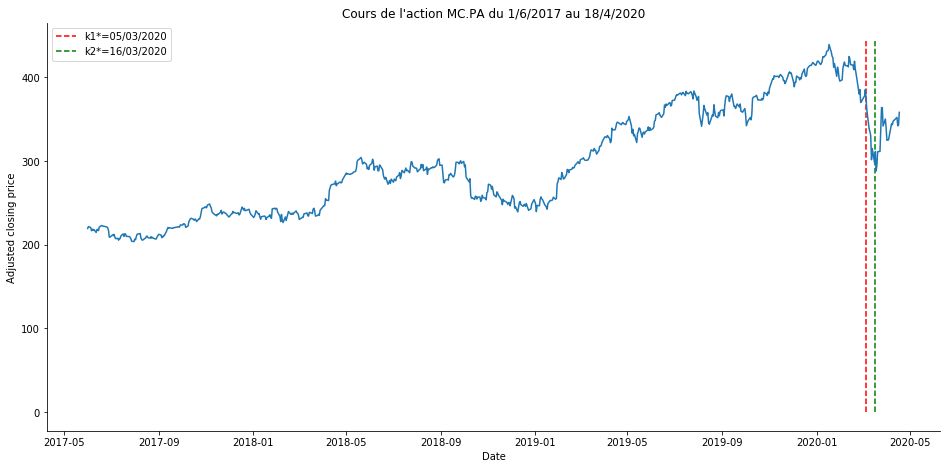

In [21]:
cours_action(Data_frame['MC.PA'],'MC.PA',T['k*'],Z['k*'])

ValueError: If using all scalar values, you must pass an index